In [10]:
from LSTMFault import LSTMAutoencoder
import train_test
import utils
import torch
from torch.utils.data import Dataset, DataLoader


In [11]:
import pandas as pd
import numpy as np 
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import glob
import os
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [12]:
# Load Dataset: Train on all the NORMAL data if the WindFarm
#Cols to drop in WFA:
columns_to_drop_WFA = ['time_stamp','train_test', 'asset_id', 'id', 'status_type_id','wind_speed_3_avg', 'wind_speed_4_avg',
       'wind_speed_3_max', 'wind_speed_3_min', 'wind_speed_3_std', 'reactive_power_27_avg', 'reactive_power_27_max',
       'reactive_power_27_min', 'reactive_power_27_std',
       'reactive_power_28_avg', 'reactive_power_28_max',
       'reactive_power_28_min', 'reactive_power_28_std', 'power_29_avg',
       'power_29_max', 'power_29_min', 'power_29_std', 'power_30_avg',
       'power_30_max', 'power_30_min', 'power_30_std']

folder_path = r'/home/raghav/TurbineProject/dataset/Normal'

# Get list of all CSV files in the folder
csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

# # Read and concatenate all CSV files
df_list = [pd.read_csv(file, sep=';') for file in csv_files]
df = pd.concat(df_list, ignore_index=True)

sensor_columns =  df.columns.drop(columns_to_drop_WFA)
data = df[sensor_columns].values

scaler = MinMaxScaler()
data = scaler.fit_transform(data)


train_data = data

X_train = utils.create_sequences(data, 5)
# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
batch_size = 16
train_loader = DataLoader(X_train, batch_size=batch_size, shuffle=True)

# Model parameters
input_size = X_train.shape[2]  # Number of sensor features
hidden_size = 64  # Adjustable
num_layers = 5  # Number of LSTM layers

model = LSTMAutoencoder(input_size, hidden_size, num_layers)
model = model.to(device)




In [13]:
# Train Model 
num_epochs = 10
train_test.train_model(model, num_epochs, train_loader, device)

Epoch [1/10], Loss: 0.0020
Epoch [2/10], Loss: 0.0006
Epoch [3/10], Loss: 0.0005
Epoch [4/10], Loss: 0.0004
Epoch [5/10], Loss: 0.0004
Epoch [6/10], Loss: 0.0004
Epoch [7/10], Loss: 0.0003
Epoch [8/10], Loss: 0.0003
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0003


In [14]:
torch.save(model, 'lstm_fault_model_WFA.pt') 
torch.save(scaler, "minmax_fault_model_WFA.pt")

In [15]:
scaler = torch.load('/home/raghav/TurbineProject/FaultPrediciton /minmax_fault_model_WFA.pt')
model_weights = r'/home/raghav/TurbineProject/FaultPrediciton /lstm_fault_model_WFA.pt'
model= torch.load(model_weights)

In [22]:
# Eval Model on train Data
train_errors, threshold = train_test.eval_model(model, train_loader, device, k=6)

In [28]:
len(train_errors)

381563

In [17]:
## Use Train Errors to get new thresholds, if needed:

# k = 6  # can be tuned (e.g., 2 or 3)
# threshold = np.mean(train_errors) + k * np.std(train_errors)

# # Option 2: Percentile method (more robust)
# threshold = np.percentile(train_errors, 95)  #

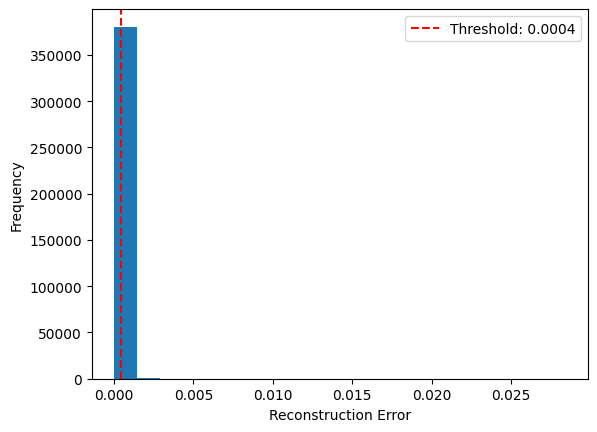

In [18]:
plt.hist(train_errors, bins=20)
plt.axvline(threshold, color='r', linestyle='--', label=f"Threshold: {threshold:.4f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [23]:
## Run inference on new Data:
file_path = r'/home/raghav/TurbineProject/dataset/26.csv'

new_errors, local_threshold, global_anomalies, local_anomalies, timestamps = utils.process_new_data(model,file_path, columns_to_drop_WFA, scaler, batch_size, threshold, device)

In [29]:
len(new_errors)

53697

In [20]:
'''
Global Anomalies: Using Threshold generated using all the Complete Dataset of the Normal Data
Local_anomalies: Usng Dataset level Threshold

'''

'\nGlobal Anomalies: Using Threshold generated using all the Complete Dataset of the Normal Data\nLocal_anomalies: Usng Dataset level Threshold\n\n'

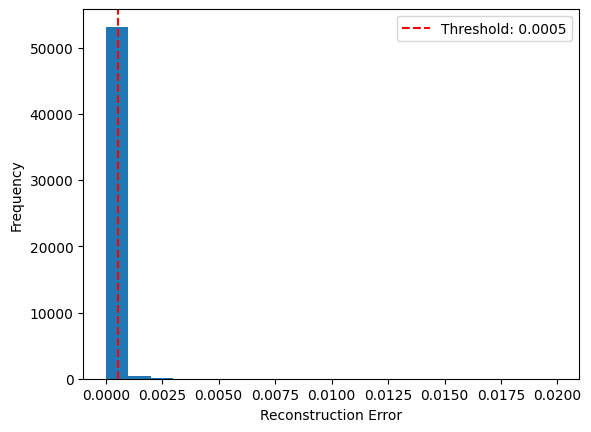

In [30]:
plt.hist(new_errors, bins=20)
plt.axvline(local_threshold, color='r', linestyle='--', label=f"Threshold: {local_threshold:.4f}")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.legend()
plt.show()


In [31]:
print(local_threshold)
print(threshold)

0.0005464769550599158
0.0004297996638342738


In [32]:
anomaly_info = list(zip(timestamps, new_errors, global_anomalies, local_anomalies))
anomaly_df = pd.DataFrame(anomaly_info, columns=['time_stamp', 'reconstruction_error', 'is_anomaly_global', 'is_anomaly_local'])


In [33]:
anomaly_df.head()

,time_stamp,reconstruction_error,is_anomaly_global,is_anomaly_local
0,2022-10-12 11:00:00,0.000198,False,False
1,2022-10-12 11:10:00,0.000224,False,False
2,2022-10-12 11:20:00,0.000215,False,False
3,2022-10-12 11:30:00,0.000195,False,False
4,2022-10-12 11:40:00,0.000174,False,False


In [40]:
#Check Anomalies in the dataset:
df2 = pd.read_csv(file_path, sep = ';')
df3 = df2[df2['train_test'] == 'prediction']
df3['status_type_id'].value_counts()


status_type_id
4    1008
3     432
0       1
Name: count, dtype: int64

In [41]:
df3[~df3['status_type_id'].isin([0])]

,time_stamp,asset_id,id,train_test,status_type_id,sensor_0_avg,sensor_1_avg,sensor_2_avg,wind_speed_3_avg,wind_speed_4_avg,...,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,sensor_52_avg,sensor_52_max,sensor_52_min,sensor_52_std,sensor_53_avg
52261,2023-10-12 10:20:00,0,52261,prediction,4,23.0,125.6,48.5,1.8,1.8,...,-1446.0,0.0,0.0,-1618.0,-1446.0,0.0,0.0,0.0,0.0,25.0
52262,2023-10-12 10:30:00,0,52262,prediction,4,23.0,92.4,15.3,1.9,1.9,...,-1188.0,0.0,0.0,-1234.0,-1188.0,0.6,1.6,0.0,0.8,25.0
52263,2023-10-12 10:40:00,0,52263,prediction,4,24.0,100.6,12.7,3.2,3.2,...,-1472.0,2458.0,0.0,-858.0,987.0,2.9,12.6,1.6,2.3,26.0
52264,2023-10-12 10:50:00,0,52264,prediction,4,24.0,106.7,3.4,4.4,4.5,...,0.0,-10003.0,0.0,18635.0,-10003.0,11.1,11.2,10.8,0.0,26.0
52265,2023-10-12 11:00:00,0,52265,prediction,4,25.0,108.1,0.2,4.7,4.8,...,0.0,-19987.0,0.0,25739.0,-19987.0,11.1,11.6,10.8,0.1,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53696,2023-10-22 09:30:00,0,53696,prediction,3,21.0,110.5,58.3,0.9,0.9,...,-5.0,0.0,0.0,-482.0,-5.0,0.0,0.0,0.0,0.0,25.0
53697,2023-10-22 09:40:00,0,53697,prediction,3,21.0,117.8,65.6,1.4,1.4,...,-6.0,0.0,0.0,-485.0,-6.0,0.0,0.0,0.0,0.0,25.0
53698,2023-10-22 09:50:00,0,53698,prediction,3,20.0,88.5,36.3,1.6,1.6,...,-257.0,0.0,0.0,-772.0,-257.0,0.5,1.7,0.0,0.8,25.0
53699,2023-10-22 10:00:00,0,53699,prediction,3,20.0,40.0,-12.2,2.0,2.0,...,-535.0,0.0,0.0,-1065.0,-535.0,1.4,1.7,0.0,0.6,25.0


In [42]:
anomaliesLocal = anomaly_df[anomaly_df['is_anomaly_local'] == True]
anomaliesLocal

,time_stamp,reconstruction_error,is_anomaly_global,is_anomaly_local
112,2022-10-13 05:40:00,0.000546,True,True
113,2022-10-13 05:50:00,0.000591,True,True
114,2022-10-13 06:00:00,0.000590,True,True
152,2022-10-13 12:20:00,0.000894,True,True
153,2022-10-13 12:30:00,0.000745,True,True
...,...,...,...,...
53582,2023-10-21 15:10:00,0.000632,True,True
53583,2023-10-21 15:20:00,0.000561,True,True
53664,2023-10-22 04:50:00,0.000814,True,True
53665,2023-10-22 05:00:00,0.000569,True,True


In [43]:
anomaly_df

,time_stamp,reconstruction_error,is_anomaly_global,is_anomaly_local
0,2022-10-12 11:00:00,0.000198,False,False
1,2022-10-12 11:10:00,0.000224,False,False
2,2022-10-12 11:20:00,0.000215,False,False
3,2022-10-12 11:30:00,0.000195,False,False
4,2022-10-12 11:40:00,0.000174,False,False
...,...,...,...,...
53692,2023-10-22 09:30:00,0.000169,False,False
53693,2023-10-22 09:40:00,0.000162,False,False
53694,2023-10-22 09:50:00,0.000176,False,False
53695,2023-10-22 10:00:00,0.000201,False,False


/tmp/ipykernel_517473/3090188561.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomaly_df['time_stamp'] = pd.to_datetime(anomaly_df['time_stamp'])
/tmp/ipykernel_517473/3090188561.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  anomaly_df = anomaly_df[df2['train_test'] == 'prediction']


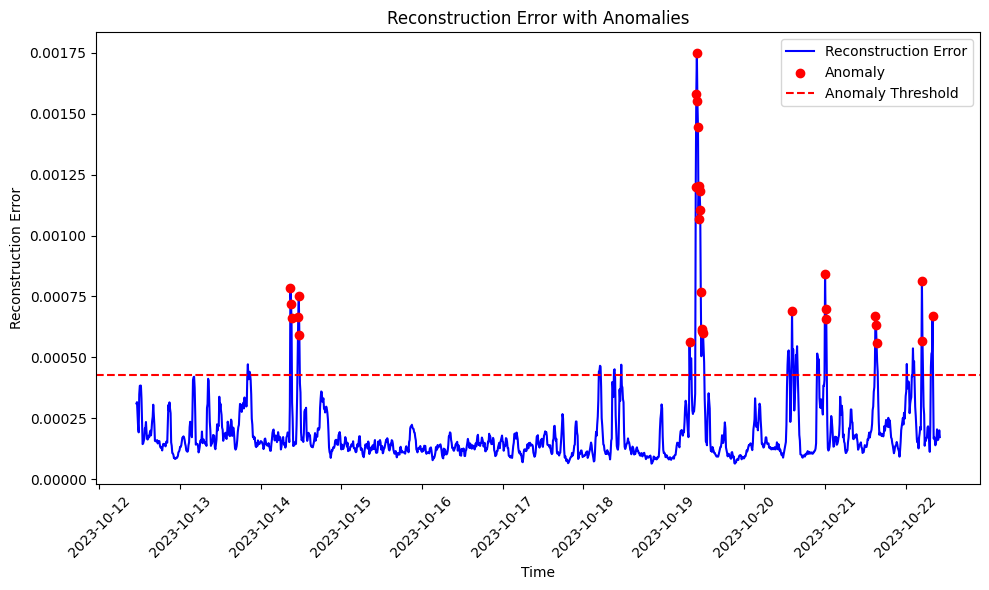

In [45]:



# Convert the timestamp to datetime
anomaly_df['time_stamp'] = pd.to_datetime(anomaly_df['time_stamp'])

# Plotting the reconstruction error
plt.figure(figsize=(10,6))
plt.plot(anomaly_df['time_stamp'], anomaly_df['reconstruction_error'], label='Reconstruction Error', color='blue')

# Highlight anomalies with red dots
anomaly_df = anomaly_df[df2['train_test'] == 'prediction']
# anomalies = anomaly_df[anomaly_df['is_anomaly_global'] == True]
anomaliesLocal = anomaly_df[anomaly_df['is_anomaly_local'] == True]

plt.scatter(anomaliesLocal['time_stamp'], anomaliesLocal['reconstruction_error'], color='red', label='Anomaly', zorder=2)
# plt.scatter(anomalies['time_stamp'], anomalies['reconstruction_error'], color='red', label='Anomaly', zorder=5)

plt.axhline(y=threshold, color='red', linestyle="dashed", label="Anomaly Threshold")
# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error with Anomalies')
plt.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [48]:
anomalies = anomaly_df[anomaly_df['is_anomaly_local'] == True]
actual_list = df3[~df3['status_type_id'].isin([0])]
actual_list = actual_list['time_stamp']
pred_list = anomalies['time_stamp']

In [50]:
# Save to excel 
data = {'timestamp_actual': pd.Series(actual_list), 'timestamp_pred': pd.Series(pred_list)}
timeframe = pd.DataFrame(data).reset_index()

timeframe.to_csv('timeframe84.csv') 

In [51]:
##### Convert Timestamps to Hourly and create a accuracy metric. 